## 성능 분석 지수

### MAE : 오차 절댓값의 평균
- 작을 수록 좋음

### RMSE : 오차 제곱 평균의 제곱근
- 작을 수록 좋음

### MPE : 오차 백분율의 평균 
- 오차를 실제값으로 나눈 값이 오차항의 백분율, 이들의 평균이 MPE
- 값의 크기로 우수 모델을 나누기보다는 오차의 편향을 탐색
- 모델에 비해 실제값이 위쪽에 있는지, 아래쪽에 위치하는지 판단

### MAPE : 오차 백분율 절댓값 평균
- MAE 값을 백분율로 산출한 값으로, MPE에 절댓값을 적용
- 같은 오차 1이라도, 실제값이 10일 때와 실제값이 100일때와 다름
- 0에 가까울수록 좋음

## fable  프레임워크
- 다양한 시게열 모델 구축, 평가, 예측을 위한 통합 프레임워크
- 평균모델, 랜덤워크, 지수 평활 모델, ARIMA, 신경망, prophet 사용 가능
- **tsibble 객체 활용**

| | fable | forecast |
| -- | -- | -- |
| 객체 | tsibble | ts |
| 단일/다중 시게열 | 다중 시계열 가능 | 단일 시계열만 가능 |
| 모델 적용 | 동시에 여러 모델 적용 | 동시에 한 모델 적용 |
| 예측 결과 | 점 예측과 분포 제공(```hilo()```함수를 통해 ```autoplot()```으로 시각화 가능) | 점 예측과 예측 범위 제공 |
| 앙상블 모델 예측 | 가능 | 불가 |

### 1. 분석 대상 시계열 데이터를 훈련/테스트 분할
### 2. fable 패키지의 ```model()```을 사용하여 동시에 생성되어야 할 모델들의 생성 함수를 넣음
### 3. 생성된 모델을 ```forecast()```를 사용하여 원하는 미래 기간만큼 (매개변수 : h)의 예측값을 산출
### 4. ```autoplot()```를 사용하여 시각화, 원본 데이터와 같이 시각화 하려면 원본 데이터를 매개변수로, 예측레벨을 시각화 하지 않으려면 level 매개변수를 NULL로
### 5. 여러 모델들의 성능 측정 지수를 확인하려면 ```forecast```결과 객체와 테스트 데이터 세트를 ```accuracy()```의 매개변수로 전달
### 6. 여러 성능 측정 지수를 확인하여 가장 성능이 좋은 모델을 선정
### 7. 선정된 모델을 사용하여 다시 ```forecast()```로 미래값을 예측하고 ```autoplot()``` 함수로 플롯 생성

|  | **함수** | **예** |
| -- | -- | -- |
| 선형 회귀 | ```TSLM()``` | ```TSLM(학생수 + trend()``` |
| 평균 모델 | ```MEAN()``` | ```MEAN(학생수)``` |
| naive | ```NAIVE()``` | ```NAIVE(학생수)``` |
| 랜덤워크 | ```RW()``` | ```RW(학생수)``` |
| 지수 평활(ets) | ```ETS()``` | ```ETS(학생수)``` |
| arima | ```ARIMA()``` | ```ARIMA(학생수)``` |
| 신경망 | ```NNETAR``` | ```NNETAR(학생수)``` |
| prophet | ```prophet(fable.prophet패키지가 필요, 소문자)``` | ```prophet(학생수)``` |

In [25]:
library(tidyverse)
library(readxl)
library(lubridate)
library(tsibble)
library(zoo)

library(showtext)
font_add("nanum", "NanumGothic.ttf")
showtext_auto()

ggplot2::theme_set(theme_bw())

In [155]:
students.all <- read_excel("C:/Users/이찬솔/Documents/시계열/students.xlsx", 
                           skip = 16, na = '-', sheet = 1, 
                           col_types = c('text', 'text', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric','numeric', 'numeric', 'numeric'))

students <- students.all %>%
  filter(지역규모 == '계') %>% select(-지역규모)

students.tsibble <- students %>%
  mutate(연도 = yearmonth(paste0(students$연도, '-01-01')))
students.tsibble <- as_tsibble(students.tsibble, index = 연도)

head(students.tsibble)
dim(students.tsibble)

연도,학생수계,유치원,초등학교,중학교,고등학교계,일반계고,전문계고,일반고,특목고,특성화고,자율고,특수학교,공민학교,고등공민,고등기술학교,각종학교
<mth>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1999 1,8658358,534166,3935537,1896956,2251140,1399389,851751,0,0,0,0,23490,150,511,8399,8009
2000 1,8535867,545263,4019991,1860539,2071468,1324482,746986,0,0,0,0,23605,150,297,6601,7953
2001 1,8414423,545142,4089429,1831152,1911173,1259975,651198,0,0,0,0,23769,140,302,5408,7908
2002 1,8361933,550256,4138366,1841030,1795509,1220146,575363,0,0,0,0,23453,145,156,4911,8107
2003 1,8379775,546531,4175626,1854641,1766529,1224452,542077,0,0,0,0,24119,105,150,4324,7750
2004 1,8371630,541713,4116195,1933543,1746560,1232010,514550,0,0,0,0,23876,106,147,3457,6033


[1] 22 17

In [35]:
split <- floor(nrow(students.tsibble) * 0.8)

students.tsibble.tr <- students.tsibble[1:split, ]
students.tsibble.test <- students.tsibble[(split+1):nrow(students.tsibble), ]

dim(students.tsibble.tr)
dim(students.tsibble.test)

[1] 17 17

[1]  5 17

In [36]:
library(fable)
library(fable.prophet)

### ```model( tsibble데이터, 모형 )```

In [38]:
model.fable.students <- model(students.tsibble.tr,
                              ets = ETS(학생수계),
                              arima = ARIMA(학생수계),
                              naive = NAIVE(학생수계),
                              tslm = TSLM(학생수계 ~ trend()),
                              rw = RW(학생수계),
                              mean = MEAN(학생수계),
                              nnetar = NNETAR(학생수계),
                              prophet = fable.prophet::prophet(학생수계)
)

n.changepoints greater than number of observations. Using 12



### ```forecast()```
- ```object``` : 모델
- ```h``` : 예측 기간

In [39]:
forecast.fable.students <- forecast(model.fable.students, h = 10)

### ```autoplot( forecast객체,  데이터, level )```
- ```level = NULL``` : 신뢰 구간 시각화 X

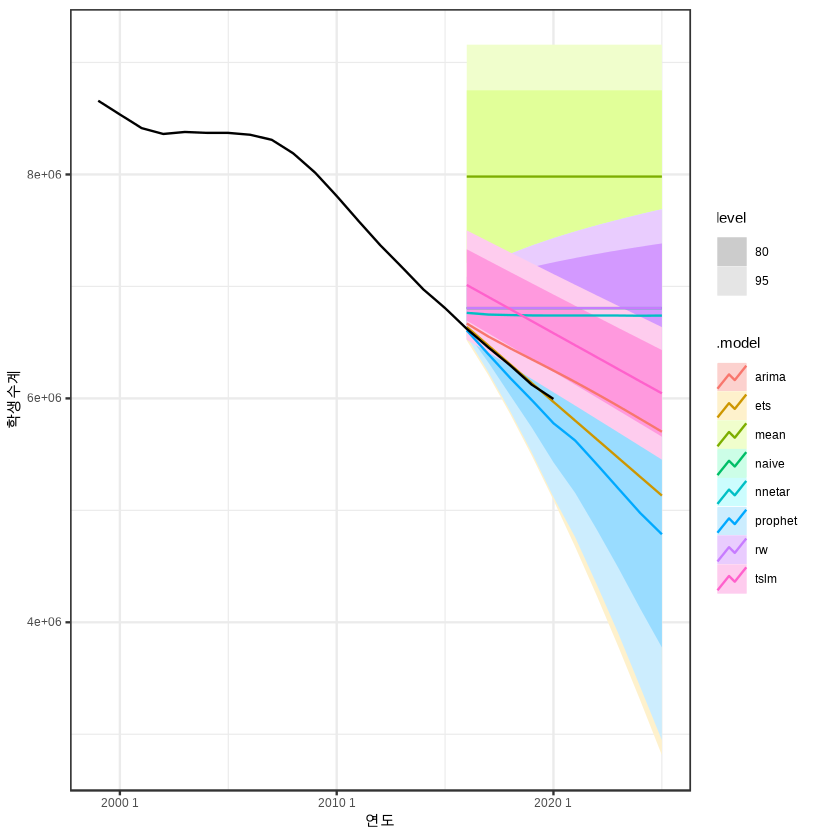

In [42]:
autoplot(forecast.fable.students, students.tsibble)

### ```accuracy( forecast객체,  test데이터 )```

In [50]:
accuracy(forecast.fable.students, students.tsibble.test) %>%
    arrange(RMSE)

Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
5 observations are missing between 2021 1 and 2025 1"


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ets,Test,-5862.37,17476.77,16448.97,-0.08622352,0.2628069,NaN,NaN,-0.07260169
prophet,Test,108024.36,128286.53,108024.36,1.75593693,1.7559369,NaN,NaN,0.31858760
arima,Test,-155457.08,173482.43,155457.08,-2.51498149,2.5149815,NaN,NaN,0.44255181
nnetar,Test,-450074.84,499439.75,450074.84,-7.27808685,7.2780869,NaN,NaN,0.41670223
tslm,Test,-499967.68,505228.60,499967.68,-7.98974725,7.9897472,NaN,NaN,0.42716020
naive,Test,-508684.80,555964.87,508684.80,-8.21432342,8.2143234,NaN,NaN,0.41256379
rw,Test,-508684.80,555964.87,508684.80,-8.21432342,8.2143234,NaN,NaN,0.41256379
mean,Test,-1683488.04,1698372.36,1683488.04,-26.89238110,26.8923811,NaN,NaN,0.41256379


- RMSE 기준 **ets**와 **prophet**이 좋은 모델

In [47]:
model.fable.students

best.model.fable.students <- model.fable.students %>%
  select(ets, prophet)

best.model.fable.students

ets,arima,naive,tslm,rw,mean,nnetar,prophet
<model>,<model>,<model>,<model>,<model>,<model>,<model>,<model>
"<ETS(A,A,N)>","<ARIMA(2,1,0) w/ drift>",<NAIVE>,<TSLM>,<NAIVE>,<MEAN>,"<NNAR(1,1)>",<prophet>


ets,prophet
<model>,<model>
"<ETS(A,A,N)>",<prophet>


Plot variable not specified, automatically selected `.vars = .fitted`


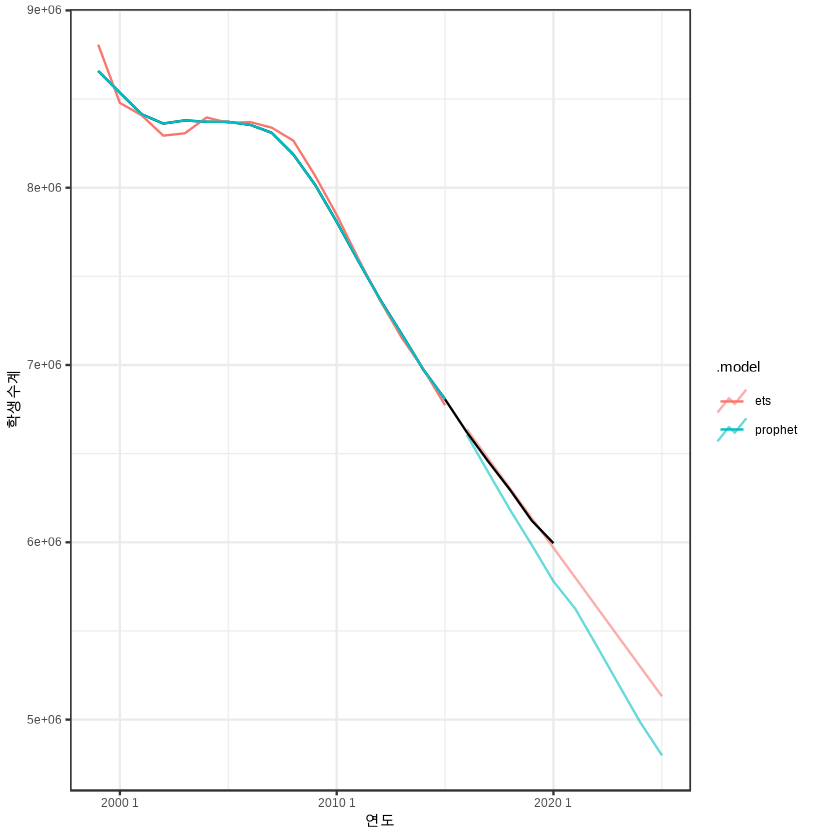

In [51]:
best.model.fable.students %>% forecast(h = 10) %>%
  autoplot(students.tsibble, alpha = 0.6, level = NULL) +
  autolayer(fitted(best.model.fable.students))

### fable 2

In [53]:
employees <- read.csv('C:/Users/이찬솔/Documents/시계열/산업별_취업자_20210206234505.csv', 
                      header = TRUE, # 철 줄은 헤더 줄로 설정
                      na = '-',  # '-'로 기록된 데이터는 NA로 설정
                      strip.white = TRUE, # 빈칸은 제거
                      stringsAsFactors = TRUE)

colnames(employees) <- c('time', 'total', 'employees.edu')
employees$time <- as.Date(paste0(employees$time, '. 01'), format = '%Y. %m. %d')
employees$yearmonth <- yearmonth(employees$time)

employees.tsibble <- as_tsibble(employees, index = yearmonth)
head(employees.tsibble)
dim(employees.tsibble)

time,total,employees.edu,yearmonth
<date>,<int>,<int>,<mth>
2013-01-01,24287,1710,2013 1
2013-02-01,24215,1681,2013 2
2013-03-01,24736,1716,2013 3
2013-04-01,25322,1745,2013 4
2013-05-01,25610,1774,2013 5
2013-06-01,25686,1786,2013 6


[1] 96  4

In [54]:
(split <- floor(nrow(employees.tsibble) * 0.9))
(n <- nrow(employees.tsibble))

employees.tsibble.tr <- employees.tsibble[1:split, ]
employees.tsibble.test <- employees.tsibble[(split+1):n, ]
dim(employees.tsibble.tr) ; dim(employees.tsibble.test)

[1] 86

[1] 96

[1] 86  4

[1] 10  4

In [55]:
model.fable.employees <- employees.tsibble.tr %>%
  model(ets = ETS(total),
        arima = ARIMA(total),
        naive = NAIVE(total),
        tslm = TSLM(total~trend() + season(12)),
        rw = RW(total),
        mean = MEAN(total),
        nnetar = NNETAR(total),
        prophet = fable.prophet::prophet(total)
  )

In [56]:
forecast.fable.employees <- model.fable.employees %>% forecast(h = 24)

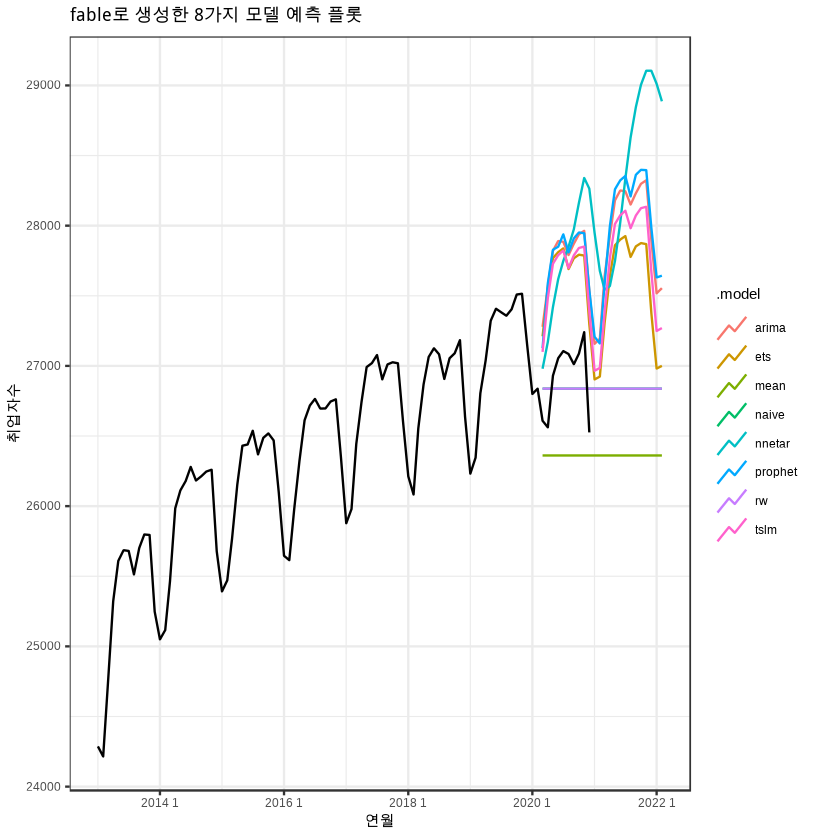

In [57]:
forecast.fable.employees %>%
  autoplot(employees.tsibble, level = NULL) +
  labs(title = 'fable로 생성한 8가지 모델 예측 플롯', x = '연월', y = '취업자수')

In [58]:
forecast.fable.employees %>% forecast::accuracy(employees.tsibble.test) %>% arrange(RMSE)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
14 observations are missing between 2021 1 and 2022 2"


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
naive,Test,83.4000,258.7532,246.8000,0.3014921,0.9166709,NaN,NaN,0.20332373
rw,Test,83.4000,258.7532,246.8000,0.3014921,0.9166709,NaN,NaN,0.20332373
mean,Test,560.0395,611.2626,560.0395,2.0721252,2.0721252,NaN,NaN,0.20332373
tslm,Test,-727.7571,737.8029,727.7571,-2.7048414,2.7048414,NaN,NaN,-0.36618171
ets,Test,-729.8212,739.7590,729.8212,-2.7131514,2.7131514,NaN,NaN,-0.06278183
prophet,Test,-827.6295,840.0940,827.6295,-3.0758193,3.0758193,NaN,NaN,-0.39657289
arima,Test,-832.8518,840.2341,832.8518,-3.0958582,3.0958582,NaN,NaN,-0.28939950
nnetar,Test,-831.6117,915.2135,831.6117,-3.0904553,3.0904553,NaN,NaN,0.45510456


Plot variable not specified, automatically selected `.vars = .fitted`
Warning message:
"Removed 2 row(s) containing missing values (geom_path)."


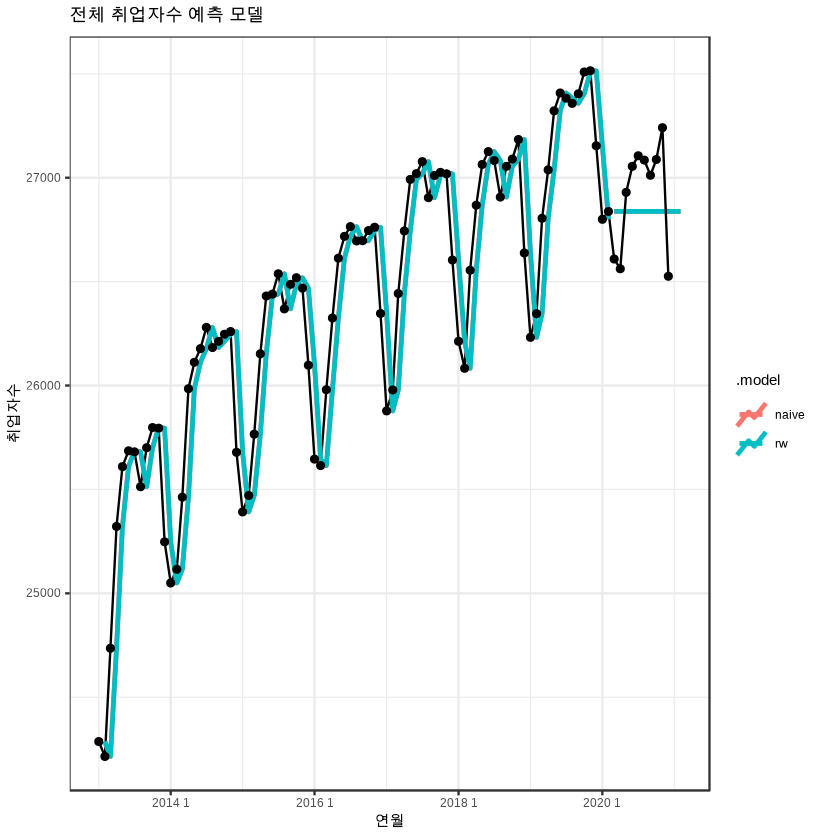

In [59]:
best.model.fable.employees <- model.fable.employees %>%
  select(naive, rw)

best.model.fable.employees %>%
  forecast(h = 12) %>%
  autoplot(employees.tsibble, level = NULL, lwd = 1) +
  autolayer(fitted(best.model.fable.employees), lwd = 1) +
  geom_point(aes(x = yearmonth, y = total)) +
  labs(title = '전체 취업자수 예측 모델', x = '연월', y = '취업자수')

### fable 3

In [70]:
covid19 <- read.csv('C:/Users/이찬솔/Documents/시계열/covid19.csv', 
                    header = TRUE, 
                    na = '-', 
                    strip.white = TRUE, 
                    stringsAsFactors = TRUE)
colnames(covid19) <- c('category', 'status', 'date', 'value')
covid19 <- covid19[, c(3, 1, 2, 4)]
covid19$date <- as.Date(covid19$date, "%Y. %m. %d")

covid19 <- covid19 %>%
  filter(grepl('세', category)) %>%
  filter(category != '세종')

covid19$value <- ifelse(is.na(covid19$value), 0, covid19$value)
covid19 <- spread(covid19, category, value)

head(covid19)

,date,status,0-9세,10-19세,20-29세,30-39세,40-49세,50-59세,60-69세,70-79세,80세 이상
,<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2020-04-09,신규,2,4,12,7,7,2,2,0,3
2,2020-04-10,신규,1,1,7,4,2,3,6,2,1
3,2020-04-11,신규,1,5,5,2,3,6,7,0,1
4,2020-04-12,신규,0,3,13,5,1,4,3,3,0
5,2020-04-13,신규,2,1,10,2,1,2,5,1,1
6,2020-04-14,신규,0,3,7,4,4,3,3,2,1


In [75]:
covid19.tsibble <- as_tsibble(covid19, index = date)
dim(covid19.tsibble)
head(covid19.tsibble)
sum(is.na(covid19.tsibble))

[1] 302  11

date,status,0-9세,10-19세,20-29세,30-39세,40-49세,50-59세,60-69세,70-79세,80세 이상
<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-04-09,신규,2,4,12,7,7,2,2,0,3
2020-04-10,신규,1,1,7,4,2,3,6,2,1
2020-04-11,신규,1,5,5,2,3,6,7,0,1
2020-04-12,신규,0,3,13,5,1,4,3,3,0
2020-04-13,신규,2,1,10,2,1,2,5,1,1
2020-04-14,신규,0,3,7,4,4,3,3,2,1


[1] 1

### ```fill_gaps()``` : 빈 값을 채움

In [76]:
fill.covid19.tsibble <- fill_gaps(covid19.tsibble, `0-9세` = 0)

In [77]:
(split <- floor(nrow(fill.covid19.tsibble) * 0.9))
(n <- nrow(fill.covid19.tsibble))

fill.covid19.tsibble.tr <- fill.covid19.tsibble[1:split, ]
fill.covid19.tsibble.test <- fill.covid19.tsibble[(split+1):n, ]
dim(fill.covid19.tsibble.tr) ; dim(fill.covid19.tsibble.test)

[1] 276

[1] 307

[1] 276  11

[1] 31 11

In [78]:
model.covid19.tsibble <- fill.covid19.tsibble.tr %>%
  model(ets = ETS(`0-9세`),
        arima = ARIMA(`0-9세`),
        naive = NAIVE(`0-9세`),
        tslm = TSLM(`0-9세`),
        rw = RW(`0-9세`),
        mean = MEAN(`0-9세`),
        nnetar = NNETAR(`0-9세`),
        prophet = prophet(`0-9세`)
  )

In [79]:
forecast.covid19.tsibble <- model.covid19.tsibble %>%
  forecast(h = 120)

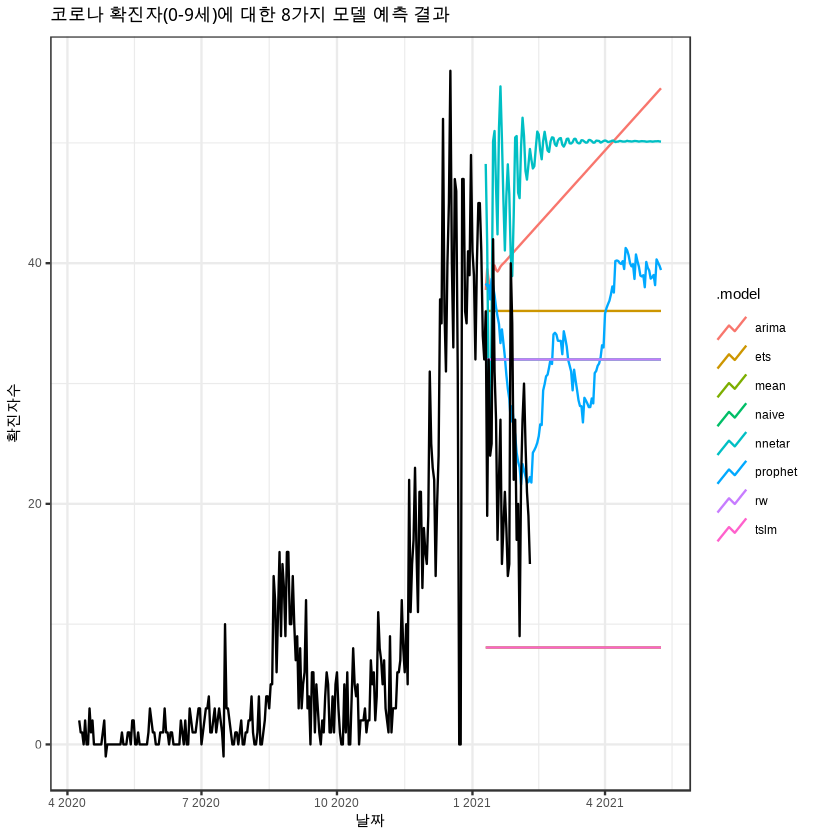

In [80]:
forecast.covid19.tsibble %>% 
    autoplot(fill.covid19.tsibble, level = NULL) + 
    labs(title = '코로나 확진자(0-9세)에 대한 8가지 모델 예측 결과', x = '날짜', y = '확진자수')

In [81]:
forecast.covid19.tsibble %>% forecast::accuracy(fill.covid19.tsibble.test) %>% arrange(RMSE)

Warning message:
"The future dataset is incomplete, incomplete out-of-sample data will be treated as missing. 
89 observations are missing between 2021-02-10 and 2021-05-09"


.model,.type,ME,RMSE,MAE,MPE,MAPE,MASE,RMSSE,ACF1
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
prophet,Test,-6.355033,10.52863,8.885563,-39.07386,46.61537,NaN,NaN,0.3740753
naive,Test,-8.387097,11.41872,10.000000,-51.73963,55.83589,NaN,NaN,0.2337242
rw,Test,-8.387097,11.41872,10.000000,-51.73963,55.83589,NaN,NaN,0.2337242
ets,Test,-12.419037,14.63818,13.060077,-70.85854,72.41531,NaN,NaN,0.2337242
mean,Test,15.554932,17.37814,15.554932,61.79020,61.79020,NaN,NaN,0.2337242
tslm,Test,15.554932,17.37814,15.554932,61.79020,61.79020,NaN,NaN,0.2337242
arima,Test,-16.773501,18.67879,16.945871,-92.12845,92.53885,NaN,NaN,0.2813732
nnetar,Test,-21.921670,24.33590,22.105223,-117.10315,117.67675,NaN,NaN,0.5297858


In [82]:
best.model.covid19.tsibble <- model.covid19.tsibble %>% select(prophet)

Plot variable not specified, automatically selected `.vars = .fitted`


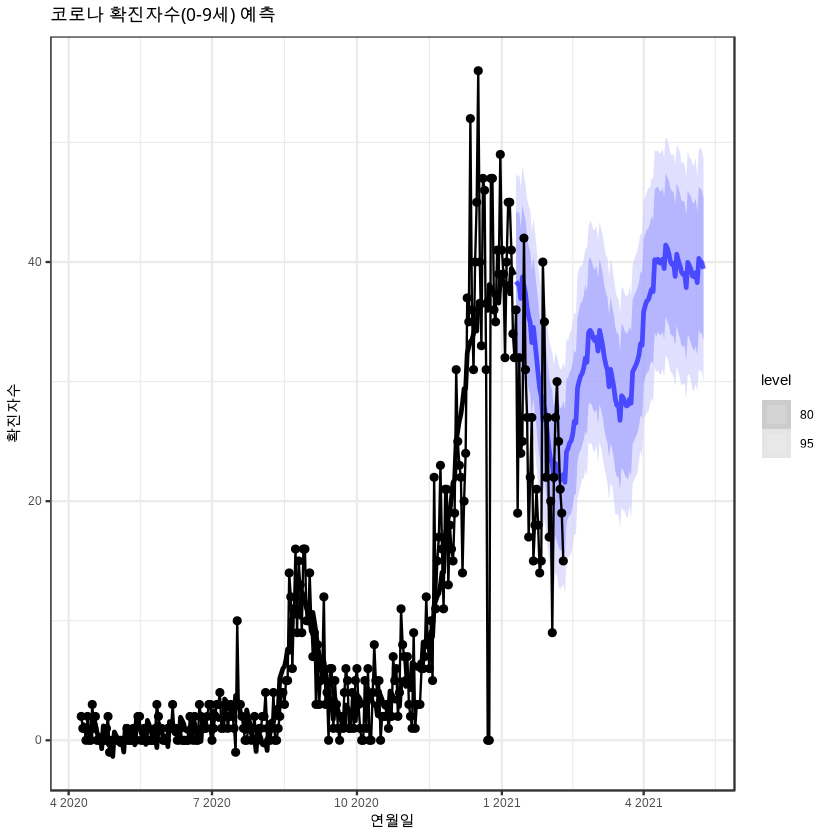

In [83]:
best.model.covid19.tsibble %>%
  forecast(h = 120) %>%
  autoplot(fill.covid19.tsibble, lwd = 1, alpha = 0.6) +
  autolayer(fitted(best.model.covid19.tsibble), lwd = 1) +
  geom_point(aes(x = date, y = `0-9세`)) +
  labs(title = '코로나 확진자수(0-9세) 예측', x = '연월일', y = '확진자수')

## modeltime 프레임워크

- tidymodel에서 포함하고 있는 tidymodel, parsnip, rsample 등의 패키지 기능 사용
- ```modeltime_table()```, ```modeltime_calibrate()```, ```modeltime_refit()``` 사용
- ```boost_tree()```, ```linear_reg()```, ```rand_forest()``` 사용 가능

### - 시계열 부스트 모델 사용 가능 
- XGBoost 모델을 오류에 적용하여 정확도를 향상시킬 수 있는 Boosted ARIMA (```arima_boost()```), Boosted Prophet (```prophet_boost()```) 사용 가능

### 1. 시게열 데이터를 훈련/테스트 분할
### 2. 모델 생성 (parsnip 패키지 제공 함수)
####    -  예측 모델 생성
####    -  ```set_engine()``` : 모델 생성에 사용할 엔진 설정
####    -  ```fit()``` : 훈련 데이터 적합

| 모델명 | 함수명 |
| -- | -- |
| 선형 회귀 | linear_reg() |
| prophet | prophet_reg() |
| boosted prophet | prophet_boost() |
| arima | arima_reg() |
| boosted arima | arima_boost() |
| 지수 평활 | exp_smoothing() |
| 계절성 회귀(tbats, stlm) | seasonal_reg() |
| 신경망 | nnetar_reg() |


### 3. 생성된 여러 모델을 모델 테이블에 저장 ```modeltime_table()```
### 4. ```modeltime_calibrate()``` : 테스트 세트를 사용하여 모델 테이블의 모델들을 조정
### 5. ```modeltime_forecast()```과 ```modeltime_accuracy()```를 사용하여 미래 예측값과, 정확성 측정
### 6. ```modeltime_refit()``` 전체 데이터를 사용해 모델을 다시 적합하고 예측값 산출

In [85]:
library(modeltime)
library(tidymodels)

### ```initial_time_split()``` : 훈련/테스트 분할
- ```data``` : 데이터
- ```prop``` : 훈련 데이터 비율

In [207]:
students.all <- read_excel("C:/Users/이찬솔/Documents/시계열/students.xlsx", 
                           skip = 16, na = '-', sheet = 1, 
                           col_types = c('text', 'text', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric', 'numeric','numeric', 'numeric', 'numeric'))

students <- students.all %>%
  filter(지역규모 == '계') %>% select(-지역규모)
students$연도 <- (as.Date(paste0(students$연도, "0101"), format="%Y%m%d"))

In [208]:
splits.students <- initial_time_split(students, prop = 0.8)

students.tr <- training(splits.students)
students.test <- testing(splits.students)

### 훈련 데이터 적합



### ```set_engine()``` : 엔진 설정
### ```fit( formula, data )``` : 적합


#### ARIMA

In [210]:
model_fit_arima <- arima_reg() %>%
  set_engine(engine = "auto_arima") %>%
  fit(학생수계 ~ 연도, data = students.tr)

frequency = 5 observations per 5 years



#### ETS

In [212]:
model_fit_ets <- exp_smoothing() %>%
  set_engine(engine = "ets") %>%
  fit(학생수계 ~ 연도, data = students.tr)

frequency = 5 observations per 5 years



#### prophet

In [214]:
model_fit_prophet <- prophet_reg() %>%
  set_engine(engine = "prophet") %>%
  fit(학생수계 ~ 연도, data = students.tr)

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

n.changepoints greater than number of observations. Using 12



#### 선형 회귀

In [216]:
model_fit_lm <- linear_reg() %>%
  set_engine("lm") %>%
  fit(학생수계 ~ 연도, data = students.tr)

#### 신경망 모델

In [218]:
model_fit_nnetar <- nnetar_reg() %>%
  set_engine("nnetar") %>%
  fit(학생수계 ~ 연도, data = students.tr)

frequency = 5 observations per 5 years



#### 계절성 회귀 TBATS

In [220]:
model_fit_tbats <- seasonal_reg() %>%
  set_engine("tbats") %>%
  fit(학생수계 ~ 연도, data = students.tr)

frequency = 5 observations per 5 years



### ```modeltime_table()``` : 모델 테이블 생성

In [241]:
models_tbl <- modeltime_table(
    model_fit_arima,
    model_fit_ets,
    model_fit_prophet,
    model_fit_lm,
    model_fit_nnetar,
    model_fit_tbats
)

models_tbl %>% print

# Modeltime Table
# A tibble: 6 x 3
  .model_id .model   .model_desc             
      <int> <list>   <chr>                   
1         1 <fit[+]> ARIMA(1,2,0)            
2         2 <fit[+]> ETS(A,A,N)              
3         3 <fit[+]> PROPHET                 
4         4 <fit[+]> LM                      
5         5 <fit[+]> NNAR(1,1,10)[5]         
6         6 <fit[+]> BATS(0.732, {0,0}, 1, -)


### 테스트 데이터를 통한 모델 조정

### ```modeltime_calibrate()``` : 저장된 모델들에 대한 조정
- ```new_data``` : 조정할 데이터

In [245]:
calibration_tbl <- models_tbl %>% 
    modeltime_calibrate(new_data = students.test)

calibration_tbl %>% print

# Modeltime Table
# A tibble: 6 x 5
  .model_id .model   .model_desc              .type .calibration_data
      <int> <list>   <chr>                    <chr> <list>           
1         1 <fit[+]> ARIMA(1,2,0)             Test  <tibble [5 x 4]> 
2         2 <fit[+]> ETS(A,A,N)               Test  <tibble [5 x 4]> 
3         3 <fit[+]> PROPHET                  Test  <tibble [5 x 4]> 
4         4 <fit[+]> LM                       Test  <tibble [5 x 4]> 
5         5 <fit[+]> NNAR(1,1,10)[5]          Test  <tibble [5 x 4]> 
6         6 <fit[+]> BATS(0.732, {0,0}, 1, -) Test  <tibble [5 x 4]> 


### 세부 조정된 모델 테이블을 적용하여 예측

### ```modeltime_forecast()```
- ```h``` : 예측 기간 (```new_data```인자 없을시)
- ```new_data``` : 예측할 데이터
- ```actual_data``` : 원 데이터

In [246]:
forecast_tbl <- calibration_tbl %>%
  modeltime_forecast(new_data = students.test,
                     actual_data = students
  )

In [247]:
head(forecast_tbl)

.model_id,.model_desc,.key,.index,.value,.conf_lo,.conf_hi
<int>,<chr>,<fct>,<date>,<dbl>,<dbl>,<dbl>
NA,ACTUAL,actual,1999-01-01,8658358,NA,NA
NA,ACTUAL,actual,2000-01-01,8535867,NA,NA
NA,ACTUAL,actual,2001-01-01,8414423,NA,NA
NA,ACTUAL,actual,2002-01-01,8361933,NA,NA
NA,ACTUAL,actual,2003-01-01,8379775,NA,NA
NA,ACTUAL,actual,2004-01-01,8371630,NA,NA


### ```plot_modeltime_forecast()``` : 예측 결과를 시각화

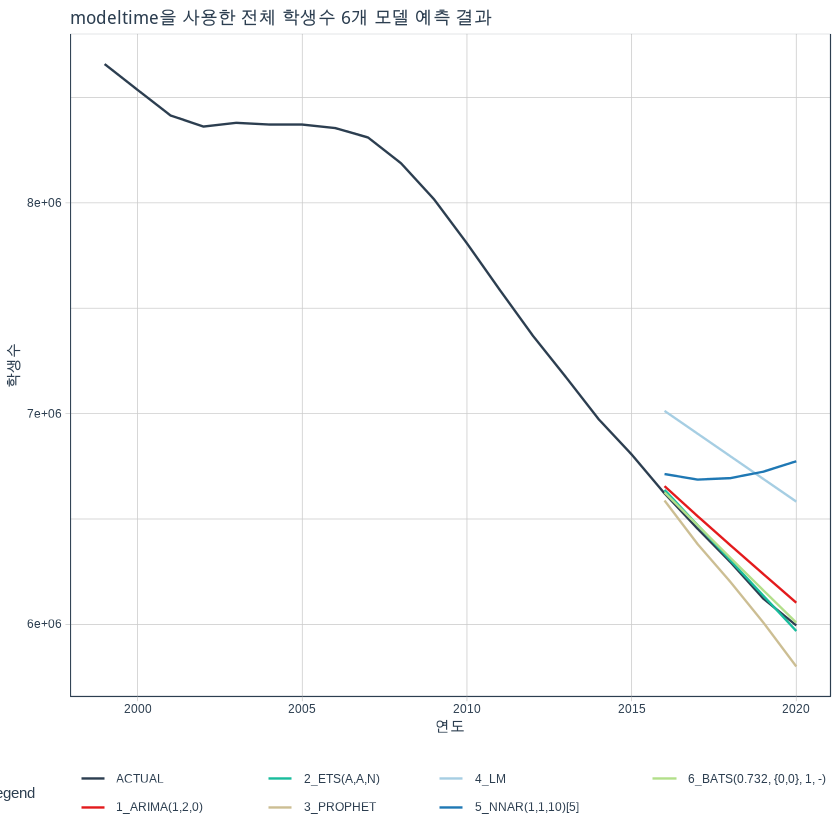

In [252]:
forecast_tbl %>% plot_modeltime_forecast(.interactive = F,
                                        .conf_interval_show = F) +
    labs(title = 'modeltime을 사용한 전체 학생수 6개 모델 예측 결과', x = '연도', y = '학생수')

### ```modeltime_accuracy()``` : 모델들의 성능 측정 지표 확인

In [253]:
calibration_tbl %>%
  modeltime_accuracy() %>%
  arrange(rmse)

.model_id,.model_desc,.type,mae,mape,mase,smape,rmse,rsq
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,"ETS(A,A,N)",Test,16448.97,0.2628069,0.1050535,0.2628013,17476.77,0.9977891
6,"BATS(0.732, {0,0}, 1, -)",Test,18767.12,0.3017548,0.1198587,0.3011235,21982.57,0.9980485
1,"ARIMA(1,2,0)",Test,79663.36,1.2829705,0.5087807,1.2734597,85226.20,0.9982611
3,PROPHET,Test,101823.60,1.6476298,0.6503101,1.6656298,115023.24,0.9959675
5,"NNAR(1,1,10)[5]",Test,420946.03,6.8319925,2.6884283,6.5276721,488074.39,0.4984445
4,LM,Test,500003.45,7.9903290,3.1933391,7.6742427,505266.46,0.9978125


### 성능 측정 지수를 사용하여 우수한 모델 두 개를 선택
### 선택된 모델에 전체 데이터 적합

In [254]:
model_fit_ets <- exp_smoothing() %>%
  set_engine(engine = "ets") %>%
  fit(학생수계 ~ 연도, data = students)

model_fit_tbats <- seasonal_reg() %>%
  set_engine("tbats") %>%
  fit(학생수계 ~ 연도, data = students)

frequency = 5 observations per 5 years

frequency = 5 observations per 5 years



In [255]:
models_tbl <- modeltime_table(
  model_fit_ets,
  model_fit_tbats)

models_tbl %>% print

# Modeltime Table
# A tibble: 2 x 3
  .model_id .model   .model_desc                 
      <int> <list>   <chr>                       
1         1 <fit[+]> ETS(A,AD,N)                 
2         2 <fit[+]> BATS(0.641, {0,0}, 0.819, -)


### 전체 데이터를 적합한 모델로 예측

Warning message:
"Expecting the following names to be in the data frame: .conf_hi, .conf_lo. 
Proceeding with '.conf_interval_show = FALSE' to visualize the forecast without confidence intervals.
Alternatively, try using `modeltime_calibrate()` before forecasting to add confidence intervals."


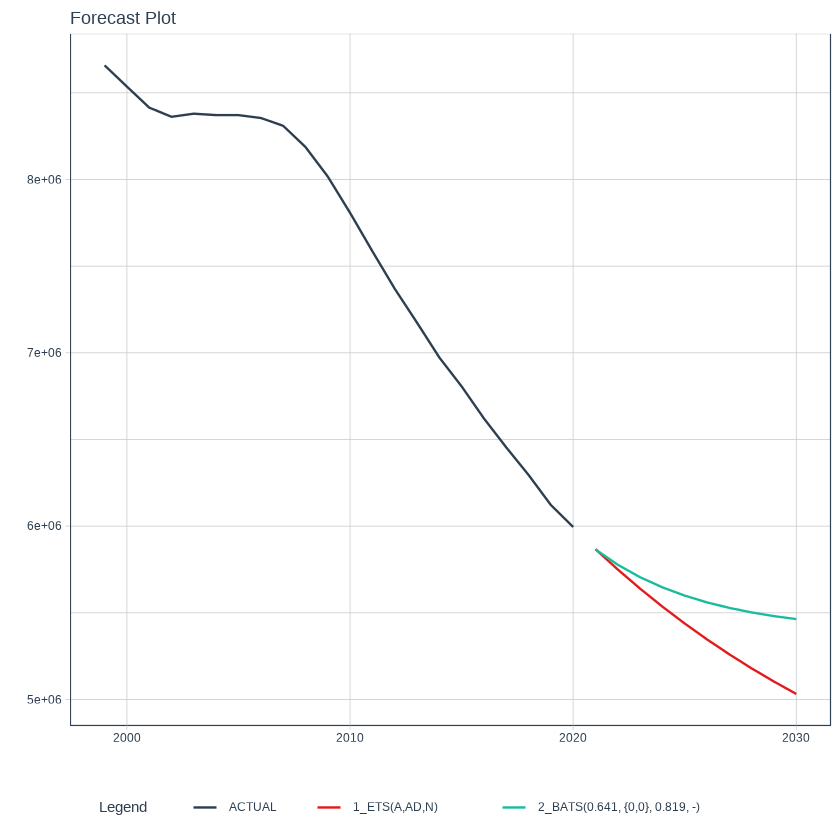

In [258]:
models_tbl %>%
  modeltime_forecast(
    h = 10,
    actual_data = students
  ) %>%
  plot_modeltime_forecast(
    .interactive = FALSE
  )

### modeltime 모델 1

In [261]:
dim(employees)

[1] 96  4

In [259]:
splits.employees <- initial_time_split(employees, prop = 0.9)

In [260]:
model_fit_arima <- arima_reg() %>%
  set_engine(engine = "auto_arima") %>%
  fit(total ~ time, data = training(splits.employees))

model_fit_ets <- exp_smoothing() %>%
  set_engine(engine = "ets") %>%
  fit(total ~ time, data = training(splits.employees))

model_fit_prophet <- prophet_reg() %>%
  set_engine(engine = "prophet") %>%
  fit(total ~ time, data = training(splits.employees))

model_fit_lm <- linear_reg() %>%
  set_engine("lm") %>%
  fit(total ~ time + factor(lubridate::month(time, label = TRUE), ordered = FALSE),
      data = training(splits.employees))

model_fit_nnetar <- nnetar_reg() %>%
  set_engine("nnetar") %>%
  fit(total ~ time, data = training(splits.employees))

model_fit_tbats <- seasonal_reg() %>%
  set_engine("tbats") %>%
  fit(total ~ time, data = training(splits.employees))

frequency = 12 observations per 1 year

frequency = 12 observations per 1 year

Disabling weekly seasonality. Run prophet with weekly.seasonality=TRUE to override this.

Disabling daily seasonality. Run prophet with daily.seasonality=TRUE to override this.

frequency = 12 observations per 1 year

frequency = 12 observations per 1 year



In [262]:
models_tbl <- modeltime_table(
  model_fit_arima,
  model_fit_ets,
  model_fit_prophet,
  model_fit_lm,
  model_fit_nnetar,
  model_fit_tbats)

models_tbl %>% print

# Modeltime Table
# A tibble: 6 x 3
  .model_id .model   .model_desc                     
      <int> <list>   <chr>                           
1         1 <fit[+]> ARIMA(0,1,1)(0,1,1)[12]         
2         2 <fit[+]> ETS(A,AD,A)                     
3         3 <fit[+]> PROPHET                         
4         4 <fit[+]> LM                              
5         5 <fit[+]> NNAR(1,1,10)[12]                
6         6 <fit[+]> TBATS(1, {0,0}, 0.971, {<12,3>})


In [263]:
calibration_tbl <- models_tbl %>%
    modeltime_calibrate(new_data = testing(splits.employees))

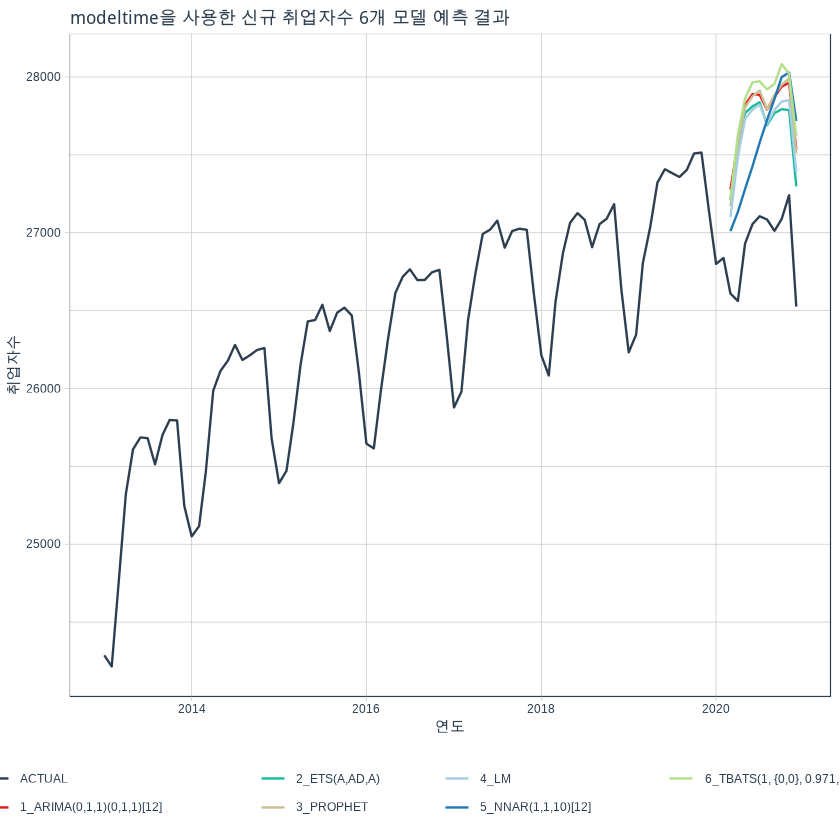

In [265]:
calibration_tbl %>%
  modeltime_forecast(
    new_data = testing(splits.employees),
    actual_data = employees
  ) %>%
  plot_modeltime_forecast(
    .interactive = FALSE,
    .conf_interval_show = FALSE
  ) + 
    labs(title = 'modeltime을 사용한 신규 취업자수 6개 모델 예측 결과', x = '연도', y = '취업자수')

In [266]:
calibration_tbl %>%
  modeltime_accuracy() %>%
  arrange(rmse)

.model_id,.model_desc,.type,mae,mape,mase,smape,rmse,rsq
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5,"NNAR(1,1,10)[12]",Test,654.1170,2.431030,3.613906,2.397202,704.6541,0.4020919
4,LM,Test,728.2075,2.706515,4.023246,2.669348,738.2471,0.7620767
2,"ETS(A,AD,A)",Test,729.8212,2.713151,4.032161,2.675809,739.7590,0.7565951
3,PROPHET,Test,824.1791,3.062818,4.553476,3.015558,833.3839,0.7598588
1,"ARIMA(0,1,1)(0,1,1)[12]",Test,832.8518,3.095858,4.601391,3.047780,840.2341,0.7953237
6,"TBATS(1, {0,0}, 0.971, {<12,3>})",Test,903.0767,3.355875,4.989374,3.299231,913.1475,0.7237029


In [267]:
model_fit_lm <- linear_reg() %>%
  set_engine("lm") %>%
  fit(total ~ time + factor(lubridate::month(time, label = TRUE), ordered = FALSE),
      data = employees)

model_fit_nnetar <- nnetar_reg() %>%
  set_engine("nnetar") %>%
  fit(total ~ time, data = employees)

frequency = 12 observations per 1 year



In [269]:
models_tbl <- modeltime_table(
  model_fit_lm,
  model_fit_nnetar)

models_tbl %>% print

# Modeltime Table
# A tibble: 2 x 3
  .model_id .model   .model_desc     
      <int> <list>   <chr>           
1         1 <fit[+]> LM              
2         2 <fit[+]> NNAR(1,1,10)[12]


Warning message:
"Expecting the following names to be in the data frame: .conf_hi, .conf_lo. 
Proceeding with '.conf_interval_show = FALSE' to visualize the forecast without confidence intervals.
Alternatively, try using `modeltime_calibrate()` before forecasting to add confidence intervals."


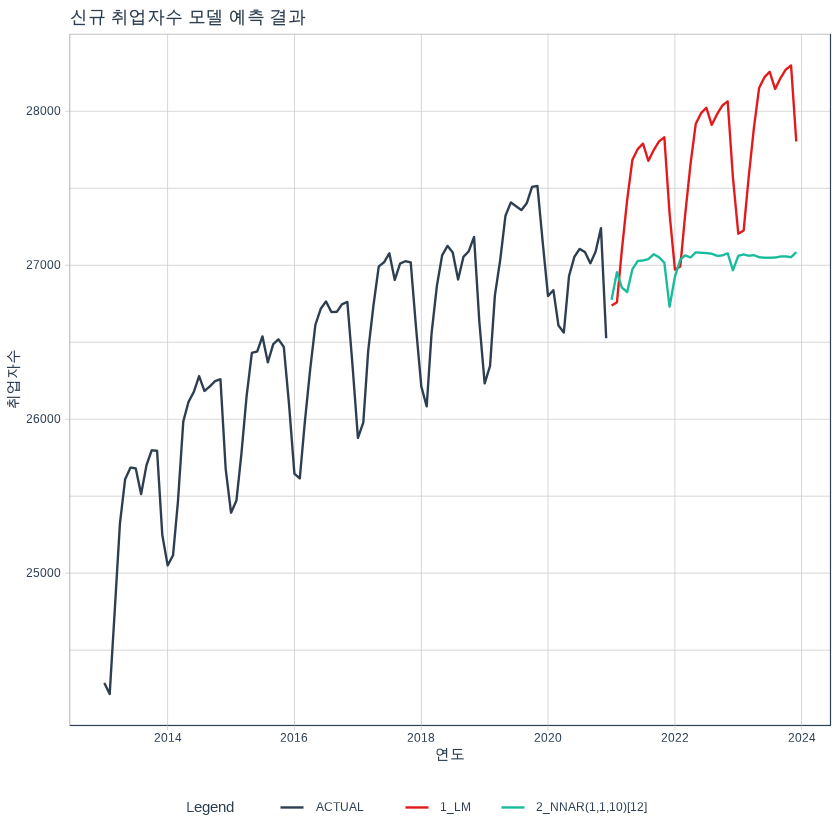

In [270]:
models_tbl %>%
  modeltime_forecast(
    h = '3 years',
    actual_data = employees
  ) %>%
  plot_modeltime_forecast(
    .interactive = FALSE
  ) + labs(title = '신규 취업자수 모델 예측 결과', x = '연도', y = '취업자수')

### modeltime 모델 2

In [272]:
dim(covid19)

[1] 302  11

In [271]:
splits.covid19 <- initial_time_split(covid19, prop = 0.9)

In [274]:
model_fit_arima <- arima_reg(seasonal_period = 365) %>%
  set_engine(engine = "auto_arima") %>%
  fit(`0-9세` ~ date, data = training(splits.covid19))

model_fit_ets <- exp_smoothing(seasonal_period = 365) %>%
  set_engine(engine = "ets") %>%
  fit(`0-9세` ~ date, data = training(splits.covid19))

model_fit_prophet <- prophet_reg(seasonality_daily = TRUE, seasonality_weekly = TRUE, ) %>%
  set_engine(engine = "prophet") %>%
  fit(`0-9세` ~ date, data = training(splits.covid19))

model_fit_lm <- linear_reg() %>%
  set_engine("lm") %>%
  fit(`0-9세` ~ date, data = training(splits.covid19))

model_fit_nnetar <- nnetar_reg() %>%
  set_engine("nnetar") %>%
  fit(`0-9세` ~ date, data = training(splits.covid19))

model_fit_tbats <- seasonal_reg() %>%
  set_engine("tbats") %>%
  fit(`0-9세` ~ date, data = training(splits.covid19))

Disabling yearly seasonality. Run prophet with yearly.seasonality=TRUE to override this.

frequency = 7 observations per 1 week

frequency = 7 observations per 1 week



In [275]:
models_tbl <- modeltime_table(
  model_fit_arima,
  model_fit_ets,
  model_fit_prophet,
  model_fit_lm,
  model_fit_nnetar,
  model_fit_tbats)

models_tbl %>% print

# Modeltime Table
# A tibble: 6 x 3
  .model_id .model   .model_desc         
      <int> <list>   <chr>               
1         1 <fit[+]> ARIMA(3,1,1)        
2         2 <fit[+]> ETS(A,N,N)          
3         3 <fit[+]> PROPHET             
4         4 <fit[+]> LM                  
5         5 <fit[+]> NNAR(1,1,10)[7]     
6         6 <fit[+]> BATS(1, {2,2}, -, -)


In [276]:
calibration_tbl <- models_tbl %>%
    modeltime_calibrate(new_data = testing(splits.covid19))

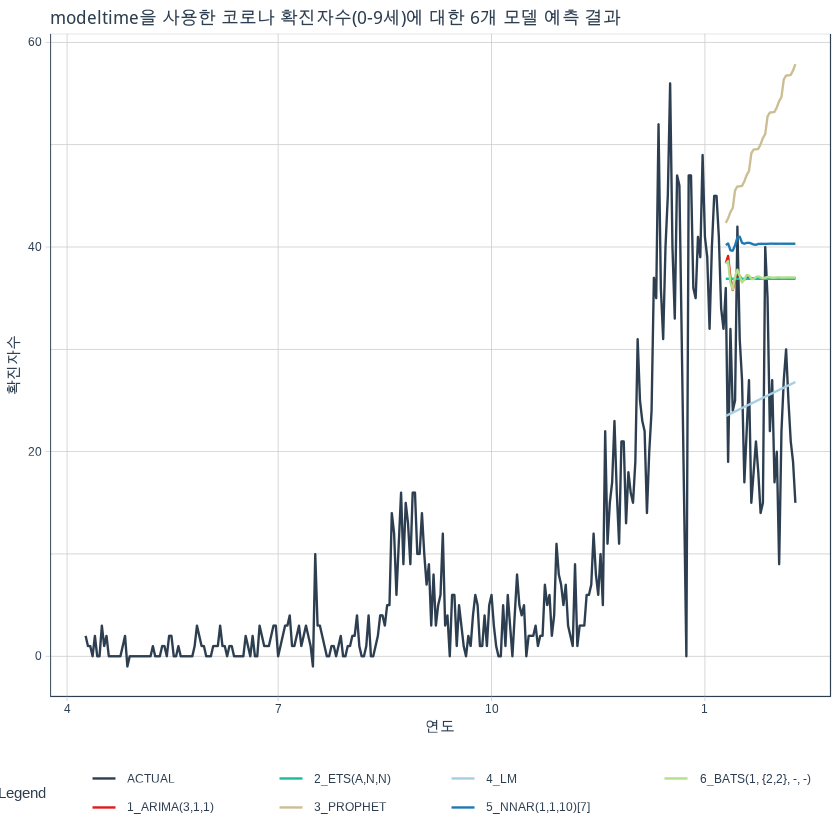

In [277]:
calibration_tbl %>%
  modeltime_forecast(
    new_data = testing(splits.covid19),
    actual_data = covid19
  ) %>%
  plot_modeltime_forecast(
    .interactive = FALSE,
    .conf_interval_show = FALSE
  ) + 
    labs(title = 'modeltime을 사용한 코로나 확진자수(0-9세)에 대한 6개 모델 예측 결과', 
         x = '연도', y = '확진자수')

In [278]:
calibration_tbl %>%
  modeltime_accuracy() %>%
  arrange(rmse)

Warning message:
"A correlation computation is required, but `estimate` is constant and has 0 standard deviation, resulting in a divide by 0 error. `NA` will be returned."


.model_id,.model_desc,.type,mae,mape,mase,smape,rmse,rsq
<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,LM,Test,6.81437,34.77145,0.9085826,28.88034,8.252107,0.09465032
2,"ETS(A,N,N)",Test,13.80919,76.22292,1.8412258,49.12520,15.374625,NA
1,"ARIMA(3,1,1)",Test,13.92437,76.78060,1.8565831,49.39969,15.478132,0.02272083
6,"BATS(1, {2,2}, -, -)",Test,13.93103,76.86470,1.8574712,49.41401,15.498622,0.03651342
5,"NNAR(1,1,10)[7]",Test,16.77034,91.29888,2.2360447,56.00613,18.395805,0.02878843
3,PROPHET,Test,26.80258,141.13444,3.5736771,74.55394,28.639048,0.07772646


In [279]:
model_fit_lm <- linear_reg() %>%
  set_engine("lm") %>%
  fit(`0-9세` ~ date,
      data = covid19)

model_fit_ets <- exp_smoothing() %>%
  set_engine(engine = "ets") %>%
  fit(`0-9세` ~ date, data = covid19)

frequency = 7 observations per 1 week



In [280]:
models_tbl <- modeltime_table(
  model_fit_lm,
  model_fit_ets)

models_tbl %>% print

# Modeltime Table
# A tibble: 2 x 3
  .model_id .model   .model_desc
      <int> <list>   <chr>      
1         1 <fit[+]> LM         
2         2 <fit[+]> ETS(A,N,N) 


Warning message:
"Expecting the following names to be in the data frame: .conf_hi, .conf_lo. 
Proceeding with '.conf_interval_show = FALSE' to visualize the forecast without confidence intervals.
Alternatively, try using `modeltime_calibrate()` before forecasting to add confidence intervals."


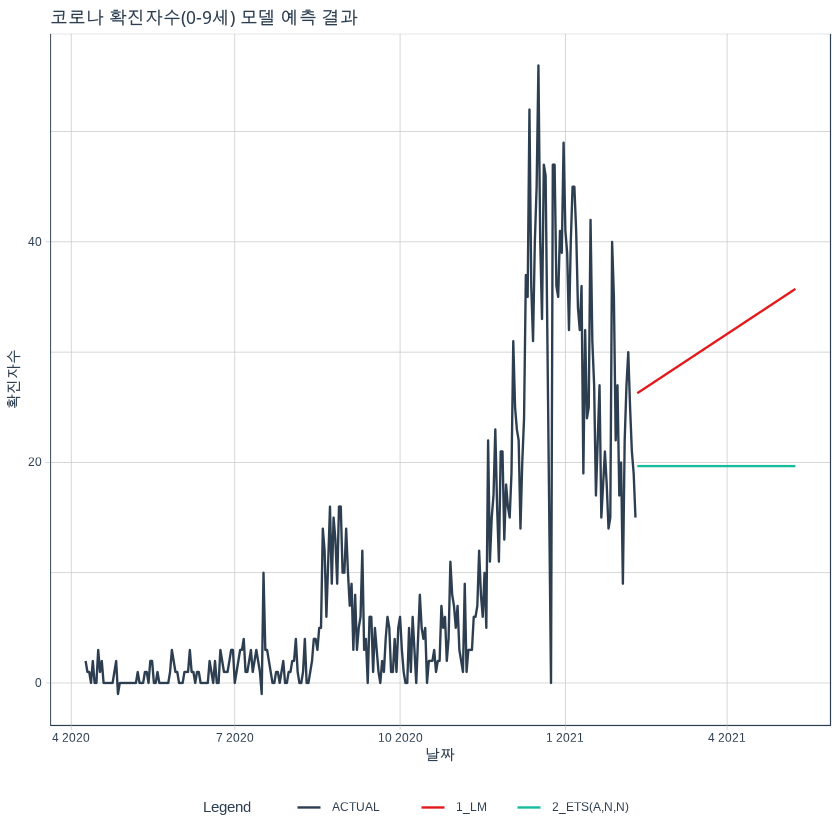

In [281]:
models_tbl %>%
  modeltime_forecast(
    h = '3 months',
    actual_data = covid19
  ) %>%
  plot_modeltime_forecast(
    .interactive = FALSE
  ) + labs(title = '코로나 확진자수(0-9세) 모델 예측 결과', x = '날짜', y = '확진자수')

## 구조적 베이지안 시계열 방법 (Bayesian Structural Time Series)

- bsts는 시계열 모델 컴포넌트로 많이 사용되는 추세(trend), 계절성(seasonality) 뿐만아니라 서로 다른 시계열 데이터 간의 상관관계를 알아내서 반영하는 회귀 컴포넌트(regression)사용자에게 익숙한 구성 요소인 주기적 및 계절적 추세와 서로 다른 시계열 간의 상관 관계를 잡아내는 회귀 구성 요소로 조합 할 수 있다

### 구조적 시계열 모델(Structural Time Series Model)

- 구조적 시계열 모델은 관측 방정식과 전이 방정식으로 표현된다.

- **관측 방정식(observation equation)은 관측 데이터(observed data) $y_t$를 ’상태(state)’로 표현되는 잠재된 변수 $\alpha_t$로 표현한다. 방정식은 다음과 같이 표현된다.**
### $y_t = Z^T_t \alpha_t + \epsilon_t$


- 전이 방정식(transition equation)은 잠재 변수 $\alpha_t$가 시간에 따라 어떻게 변하는 지를 설명한다.
### $\alpha_{t+1} = T_t \alpha_t + R_t \eta_t$

### 잠재변수
- 여기서 ARIMA나 다른 시계열 모델링에 표현되지 않았던 잠재된 변수라는 개념이 등장한다. **잠재 변수는 관찰되지 않은 추세(unobserved trend)이다.** 예를 들어 잠재된 브랜드 가치의 성장이나 정밀하기 측정이 어려운 외부 요인들을 표현할 수 있다.
- **위의 두 방정식에서 오류를 나타내는 $\epsilon_t$과 $\eta_t$은 독립적 변수로 다른 변수의 영향을 받지 않고 정규분포하는 백색잡음이다.** $Z_t$, $T_t$, $R_t$는 구조적 매개변수 배열을 의미한다. 따라서 관측방정식의 결과값 $Y_t$는 잠재변수 $\alpha_t$에 의해 결정되고 전이 방정식의 결과값 $\alpha_{t+1}$은 $\alpha_t$에 의해 결정된다.
- 이 방정식에서 $Z_t, T_t, R_t$를 모두 1로 설정하고 $\alpha_t$를 $\mu_t$로 치환해서 표현하면 다음과 같이 표현이 가능하다. 이 모델이 ’local level model’인데 노이즈에서 관찰되는 랜덤워크 모델로 가장 간단하지만 유용한 모델이다.
### $y_t = \mu_t + \epsilon_t$
### $\mu_{t+1} = \mu_t + \eta_t$

- 구조적 시계열 모델은 유연하고 모듈화되어 유용하다. 분석자는 단기 예측을 할 지, 장기 예츨을 할 지, 계절성이 포함되어 있는지 아닌지, 회귀 연산자를 포함하는지, 어떻게 포함하는지 등에 따라 αt를 결정할 수 있다.

- 만약 계절성과 회귀연산자를 모두 포함한다면 위의 방정식은 아래와 같이 변경될 수 있다.
### $Y_t = \mu_t + x_i \beta + S + \epsilon_t$

- 여기서 xt는 회귀자(regressor), β는 회귀계수, S는 계절성을 의미한다. $\mu_t$를 사용했기 때문에 결국 local level model을 기반으로 한다는 것을 나타낸다.

In [283]:
library(bsts)

In [288]:
students.xts <- as.xts(students[,-1], order.by = students$연도)
head(students.xts[, 1])

           학생수계
1999-01-01  8658358
2000-01-01  8535867
2001-01-01  8414423
2002-01-01  8361933
2003-01-01  8379775
2004-01-01  8371630

### 상태공간 설정
### ```AddLocalLinearTrend()``` : 선형 트렌드를 추가한 상태공간 모델을 생성

In [291]:
students.ss <- AddLocalLinearTrend(list(), students.xts[, 1])
students.ss %>% summary()

     Length Class            Mode
[1,] 6      LocalLinearTrend list

### ```AddSeasonal()``` : 계절성 추가
students.ss <- AddSeasonal(students.ss, students.xts[, 1], nseasons = 1)

### ```bsts()``` : 상태공간 모델을 사용하여 구조적 베이지안 시계열 모델 생성
- ```state.specification``` : 상태공간 모델
- ```niter``` : 반복횟수 (MCMC 샘플 수)

In [292]:
students.bayesian.model <- bsts(students.xts[, 1],
                                state.specification = students.ss,
                                niter = 1000)

=-=-=-=-= Iteration 0 Mon Apr 18 23:02:46 2022
 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Apr 18 23:02:46 2022
 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Apr 18 23:02:46 2022
 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Apr 18 23:02:46 2022
 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Apr 18 23:02:46 2022
 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Apr 18 23:02:47 2022
 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Apr 18 23:02:47 2022
 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Apr 18 23:02:47 2022
 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Apr 18 23:02:47 2022
 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Apr 18 23:02:47 2022
 =-=-=-=-=


- btst()는 fitted()를 사용할 수 없기 떄문에 적합값을 직접 구해야 한다. btst()의 결과는 bsts 클래스인데 여기에는 원스텝 예측 오류값이 저장된다. 이 오류값은 MCMC 샘플수 만큼 생성되는데 이 오류값들의 평균값을 예측 오류값으로 볼 수 있다. 이 값을 실측값에서 빼주면 적합값이 산출된다.  

In [302]:
attributes(students.bayesian.model)
students.bayesian.model %>% summary()

$names
 [1] "sigma.obs"                  "sigma.trend.level"         
 [3] "sigma.trend.slope"          "final.state"               
 [5] "state.contributions"        "one.step.prediction.errors"
 [7] "log.likelihood"             "has.regression"            
 [9] "state.specification"        "prior"                     
[11] "timestamp.info"             "model.options"             
[13] "family"                     "niter"                     
[15] "original.series"           

$class
[1] "bsts"

$residual.sd
[1] 33025.57

$prediction.sd
[1] 50503.15

$rsquare
[1] 0.9986254

$relative.gof
[1] 0.5574071

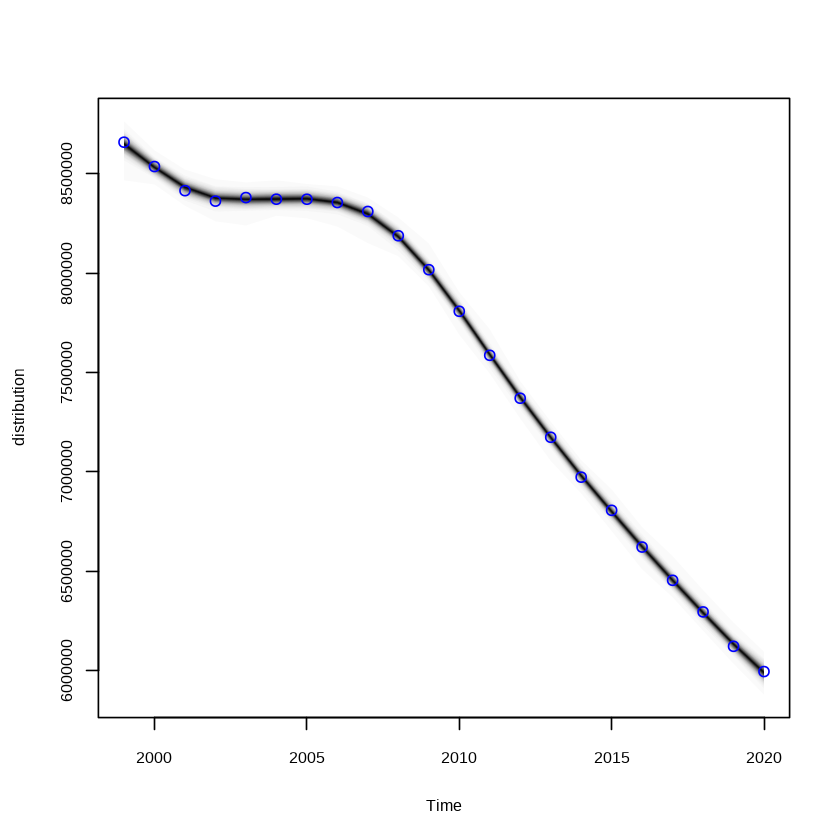

In [303]:
plot(students.bayesian.model) # plot(students.bayesian.model, "components") 

### ```SuggestBurn()``` : MCMC에서 Burn-in으로 사용할 수 산출
- ```proportion``` : 비율}
- ```bsts.object``` : bsts 객체

In [343]:
(students.burn <- SuggestBurn(0.1, students.bayesian.model))

[1] 1

### 예측을 시행할 기간 지정

In [306]:
students.horizon.pred <- 5

### ```predict.bsts()``` : 구조적 베이지안 시게열 모델을 사용하여 예측치 생성
- ```object``` : bsts 모델
- ```horizon```: 예측 기간
- ```burn``` : burn
- ```quantiles``` : 예측 신뢰구간

In [307]:
students.bayesian.pred <- predict.bsts(students.bayesian.model, 
                                       horizon = students.horizon.pred, 
                                       burn = students.burn, 
                                       quantiles = c(.025, .975))

In [330]:
attributes(students.bayesian.pred)

$names
[1] "mean"            "median"          "interval"        "distribution"   
[5] "original.series"

$class
[1] "bsts.prediction"

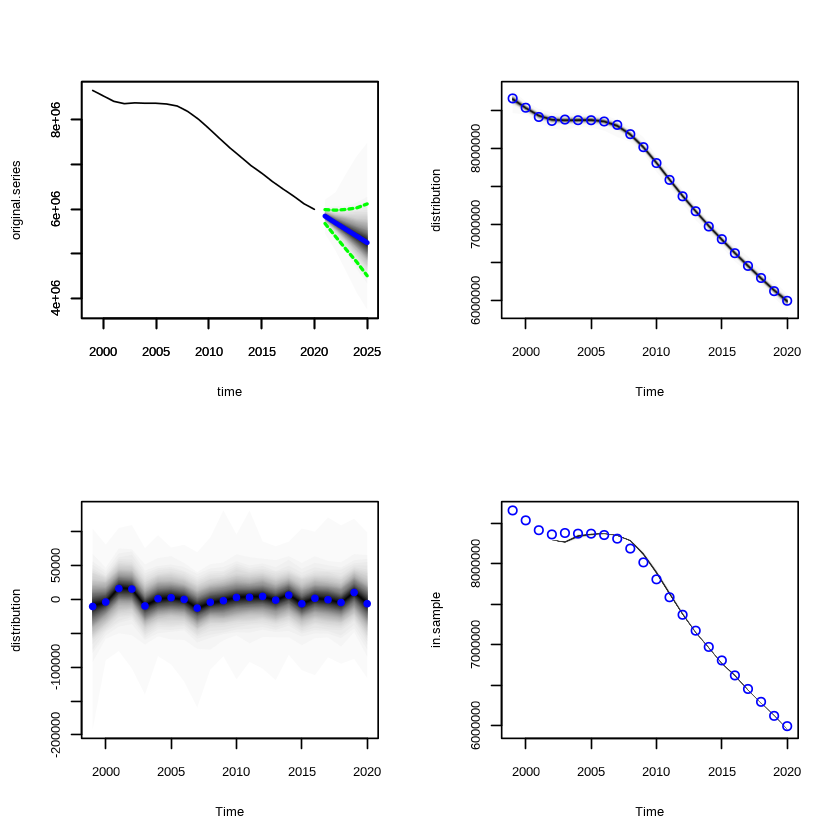

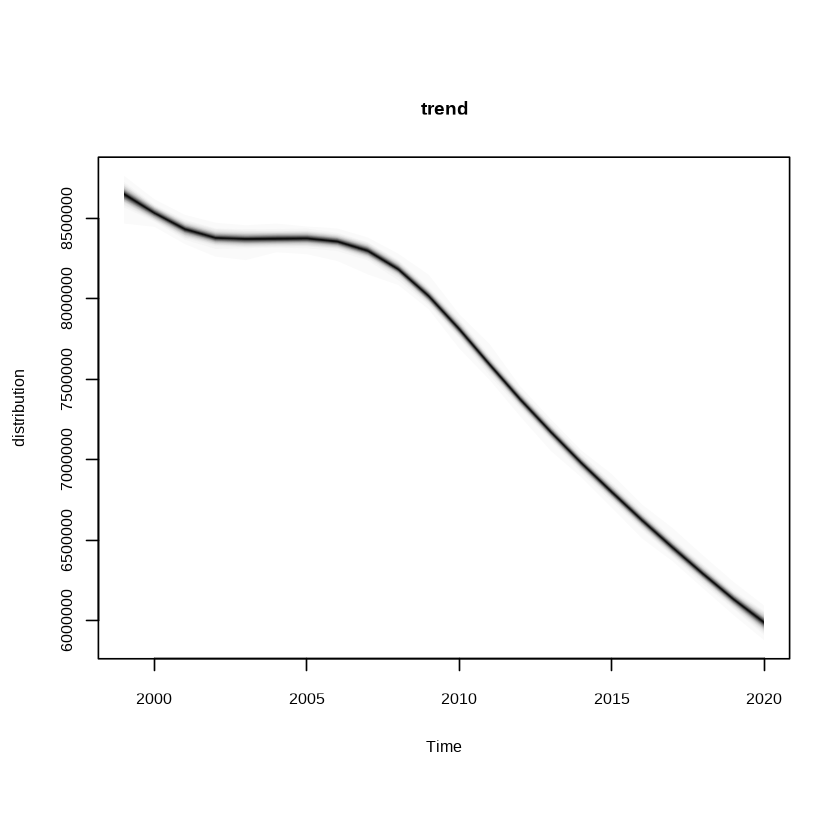

In [326]:
par(mfrow = c(2, 2))
plot(students.bayesian.pred)
plot(students.bayesian.model)
plot(students.bayesian.model, "residuals")
plot(students.bayesian.model, "forecast.distribution")
plot(students.bayesian.model, "components")

In [329]:
students.bayesian.df <- data.frame(
  # fitted values and predictions
  c(time(students.xts[, 1]), seq(max(time(students.xts[, 1])) + years(1), by = 'years', length.out = students.horizon.pred)),
  c(as.numeric(students.xts[, 1]), rep(NA, students.horizon.pred)),
  c(as.numeric(-colMeans(students.bayesian.model$one.step.prediction.errors[-(1:students.burn),]) + students.xts[, 1]),  
    as.numeric(students.bayesian.pred$mean))
)

names(students.bayesian.df) <- c('Date', 'Actual', "Fitted")

tail(students.bayesian.df)

,Date,Actual,Fitted
,<date>,<dbl>,<dbl>
22,2020-01-01,5995239,5955694
23,2021-01-01,NA,5840315
24,2022-01-01,NA,5696735
25,2023-01-01,NA,5551660
26,2024-01-01,NA,5405266
27,2025-01-01,NA,5261093


In [331]:
MAPE <- students.bayesian.df %>% 
  filter(is.na(Actual) == F) %>% 
  summarise(MAPE = mean(abs(Actual - Fitted) / Actual))

In [332]:
students.bayesian.posterior.interval <- data.frame(
  filter(students.bayesian.df, is.na(Actual) == T)[, 1],
  students.bayesian.pred$interval[1,],
  students.bayesian.pred$interval[2,]
)

names(students.bayesian.posterior.interval) <- c("Date", "LL", "UL")
head(students.bayesian.posterior.interval)

,Date,LL,UL
,<date>,<dbl>,<dbl>
1,2021-01-01,5678338,5988446
2,2022-01-01,5386180,5975959
3,2023-01-01,5098353,5993190
4,2024-01-01,4818866,6026389
5,2025-01-01,4507360,6116655


In [334]:
students.bayesian.df.pred <- left_join(students.bayesian.df, 
                                       students.bayesian.posterior.interval, 
                                       by="Date")

tail(students.bayesian.df.pred)

,Date,Actual,Fitted,LL,UL
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
22,2020-01-01,5995239,5955694,NA,NA
23,2021-01-01,NA,5840315,5678338,5988446
24,2022-01-01,NA,5696735,5386180,5975959
25,2023-01-01,NA,5551660,5098353,5993190
26,2024-01-01,NA,5405266,4818866,6026389
27,2025-01-01,NA,5261093,4507360,6116655


Warning message:
"Removed 5 row(s) containing missing values (geom_path)."


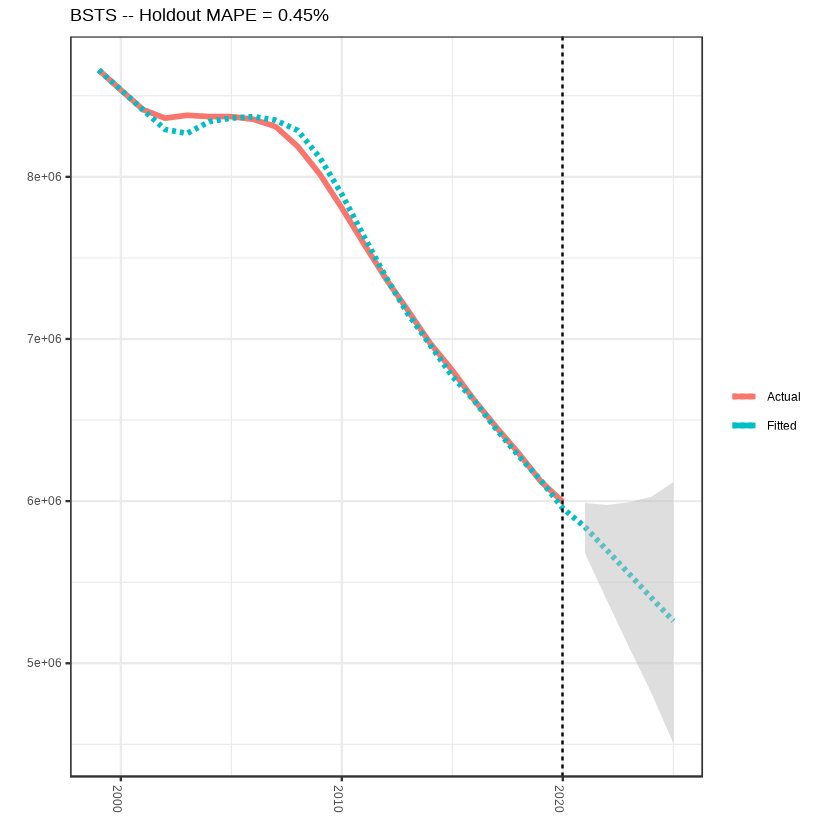

In [336]:
students.bayesian.df.pred %>% 
  ggplot(aes(x = Date)) +
  geom_line(aes(y=Actual, colour = "Actual"), size = 1.2) +
  geom_line(aes(y=Fitted, colour = "Fitted"), size = 1.2, linetype = 2) +
  theme(legend.title = element_blank()) + ylab("") + xlab("") +
  geom_vline(xintercept = as.numeric(as.Date("2020-01-01")), linetype = 2) + 
  geom_ribbon(aes(ymin = LL, ymax = UL), fill = "grey", alpha = 0.5) +
  ggtitle(paste0("BSTS -- Holdout MAPE = ", round(100 * MAPE, 2), "%")) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0))

### bsts 모델 1

In [337]:
head(employees)

,time,total,employees.edu,yearmonth
,<date>,<int>,<int>,<mth>
1,2013-01-01,24287,1710,2013 1
2,2013-02-01,24215,1681,2013 2
3,2013-03-01,24736,1716,2013 3
4,2013-04-01,25322,1745,2013 4
5,2013-05-01,25610,1774,2013 5
6,2013-06-01,25686,1786,2013 6


In [338]:
employees.ss <- AddLocalLinearTrend(list(), employees$total)
employees.ss <- AddSeasonal(employees.ss, employees$total, nseasons = 12)

In [339]:
employees.bayesian.model <- bsts(employees$total,
                                state.specification = employees.ss,
                                niter = 1000)

=-=-=-=-= Iteration 0 Mon Apr 18 23:34:07 2022
 =-=-=-=-=
=-=-=-=-= Iteration 100 Mon Apr 18 23:34:07 2022
 =-=-=-=-=
=-=-=-=-= Iteration 200 Mon Apr 18 23:34:08 2022
 =-=-=-=-=
=-=-=-=-= Iteration 300 Mon Apr 18 23:34:08 2022
 =-=-=-=-=
=-=-=-=-= Iteration 400 Mon Apr 18 23:34:09 2022
 =-=-=-=-=
=-=-=-=-= Iteration 500 Mon Apr 18 23:34:09 2022
 =-=-=-=-=
=-=-=-=-= Iteration 600 Mon Apr 18 23:34:09 2022
 =-=-=-=-=
=-=-=-=-= Iteration 700 Mon Apr 18 23:34:10 2022
 =-=-=-=-=
=-=-=-=-= Iteration 800 Mon Apr 18 23:34:10 2022
 =-=-=-=-=
=-=-=-=-= Iteration 900 Mon Apr 18 23:34:11 2022
 =-=-=-=-=


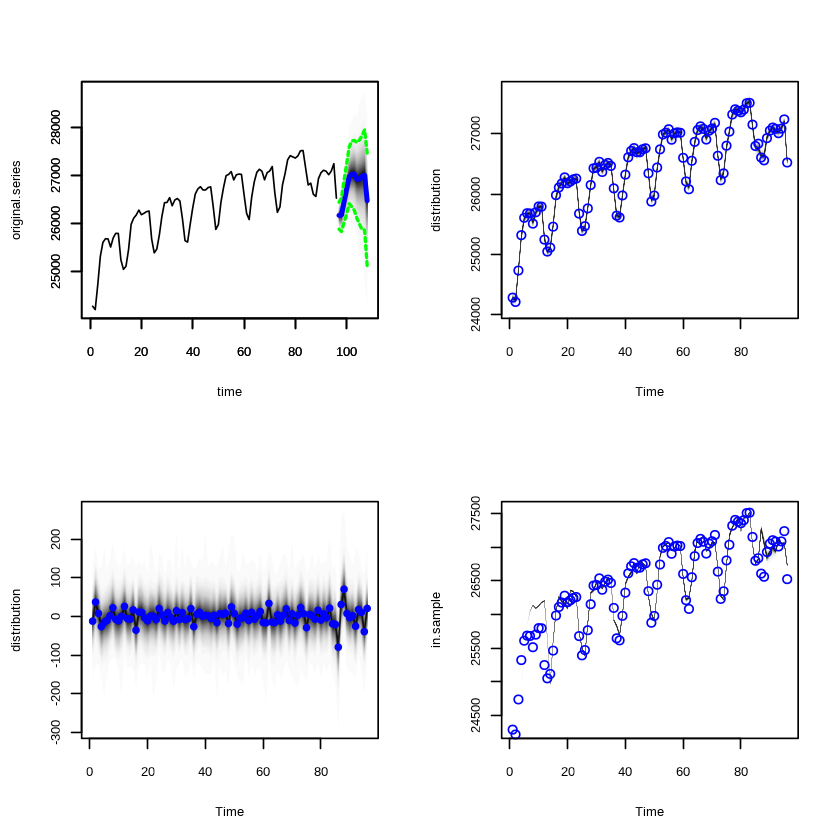

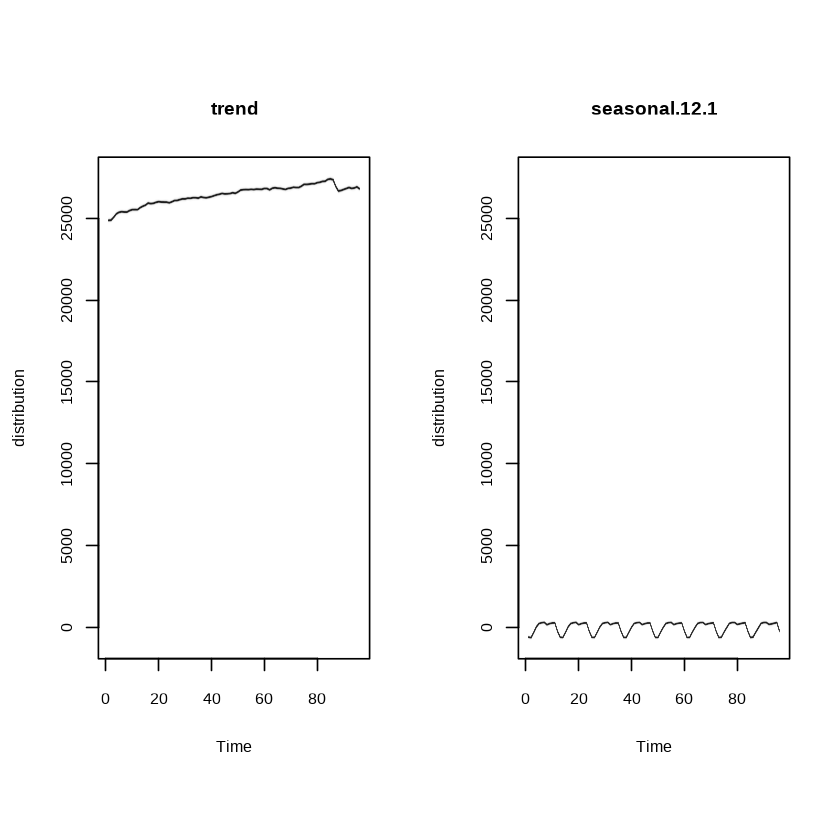

In [356]:
par(mfrow = c(2,2))
plot(employees.bayesian.pred)
plot(employees.bayesian.model)
plot(employees.bayesian.model, "residuals")
plot(employees.bayesian.model, "forecast.distribution")
plot(employees.bayesian.model, "components")

In [342]:
(employees.burn <- SuggestBurn(0.1, employees.bayesian.model))
employees.horizon.pred <- 12

[1] 104

In [345]:
employees.bayesian.pred <- predict.bsts(employees.bayesian.model, 
                                       horizon = employees.horizon.pred, 
                                       burn = employees.burn, 
                                       quantiles = c(.025, .975))

In [349]:
employees.bayesian.df <- data.frame(
  c(employees$time, seq(max(employees$time) + months(1), by = 'month', length.out = employees.horizon.pred)),
  c(as.numeric(employees$total), rep(NA, employees.horizon.pred)),
  c(as.numeric(-colMeans(employees.bayesian.model$one.step.prediction.errors[-(1:employees.burn),])+employees$total),  
    as.numeric(employees.bayesian.pred$mean))
)


names(employees.bayesian.df) <- c('Date', 'Actual', "Fitted")
tail(employees.bayesian.df)

,Date,Actual,Fitted
,<date>,<dbl>,<dbl>
103,2021-07-01,NA,27022.38
104,2021-08-01,NA,26903.72
105,2021-09-01,NA,26919.94
106,2021-10-01,NA,26954.96
107,2021-11-01,NA,26978.94
108,2021-12-01,NA,26432.50


In [348]:
MAPE <- employees.bayesian.df %>% 
  filter(is.na(Actual) == F) %>% 
  summarise(MAPE = mean(abs(Actual - Fitted) / Actual))

In [350]:
employees.bayesian.posterior.interval <- data.frame(
  filter(employees.bayesian.df, is.na(Actual) == T)[, 1],
  employees.bayesian.pred$interval[1,],
  employees.bayesian.pred$interval[2,]
)

names(employees.bayesian.posterior.interval) <- c("Date", "LL", "UL")
tail(employees.bayesian.posterior.interval)

,Date,LL,UL
,<date>,<dbl>,<dbl>
7,2021-07-01,26272.77,27724.84
8,2021-08-01,26108.48,27678.46
9,2021-09-01,25991.19,27734.15
10,2021-10-01,25868.56,27824.98
11,2021-11-01,25865.55,27945.14
12,2021-12-01,25119.38,27462.14


In [351]:
employees.bayesian.df.pred <- left_join(employees.bayesian.df, 
                                        employees.bayesian.posterior.interval, by="Date")
head(employees.bayesian.df.pred)

,Date,Actual,Fitted,LL,UL
,<date>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,24287,24287.00,NA,NA
2,2013-02-01,24215,24310.32,NA,NA
3,2013-03-01,24736,24318.87,NA,NA
4,2013-04-01,25322,24818.96,NA,NA
5,2013-05-01,25610,25417.60,NA,NA
6,2013-06-01,25686,25829.75,NA,NA


Warning message:
"Removed 12 row(s) containing missing values (geom_path)."


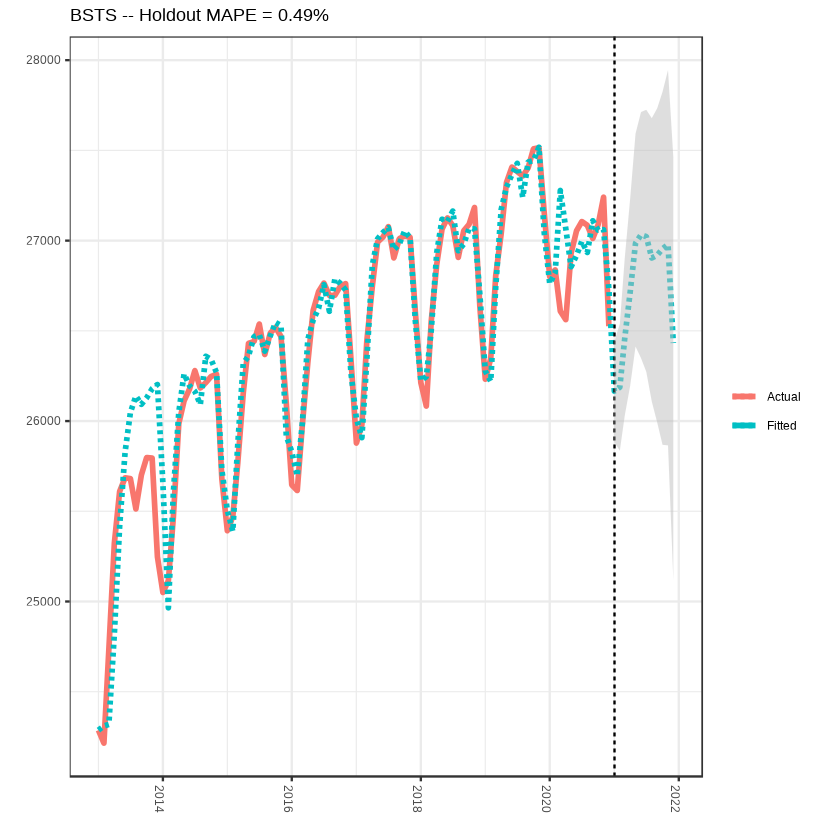

In [353]:
employees.bayesian.df.pred %>% 
  ggplot(aes(x=Date)) +
  geom_line(aes(y = Actual, colour = "Actual"), size = 1.2) +
  geom_line(aes(y = Fitted, colour = "Fitted"), size = 1.2, linetype = 2) +
  theme(legend.title = element_blank()) + ylab("") + xlab("") +
  geom_vline(xintercept = as.numeric(as.Date("2021-01-01")), linetype = 2) + 
  geom_ribbon(aes(ymin = LL, ymax = UL), fill="grey", alpha = 0.5) +
  ggtitle(paste0("BSTS -- Holdout MAPE = ", round(100 * MAPE, 2), "%")) +
  theme(axis.text.x = element_text(angle = -90, hjust = 0))

### bsts 모델 2

In [359]:
covid19.xts <- as.xts(covid19[, 3:10], order.by = covid19$date)
head(covid19.xts[, 1]) 
dim(covid19.xts)

           0-9세
2020-04-09     2
2020-04-10     1
2020-04-11     1
2020-04-12     0
2020-04-13     2
2020-04-14     0

[1] 302   8

In [360]:
covid19.ss <- AddLocalLinearTrend(list(), covid19.xts[, 1])
covid19.ss <- AddSeasonal(covid19.ss, covid19.xts[, 1], nseasons = 52, season.duration = 7)

In [361]:
covid19.bayesian.model <- bsts(covid19.xts[, 1],
                               state.specification = covid19.ss,
                               niter = 100)

=-=-=-=-= Iteration 0 Mon Apr 18 23:42:30 2022
 =-=-=-=-=
=-=-=-=-= Iteration 10 Mon Apr 18 23:42:30 2022
 =-=-=-=-=
=-=-=-=-= Iteration 20 Mon Apr 18 23:42:31 2022
 =-=-=-=-=
=-=-=-=-= Iteration 30 Mon Apr 18 23:42:31 2022
 =-=-=-=-=
=-=-=-=-= Iteration 40 Mon Apr 18 23:42:31 2022
 =-=-=-=-=
=-=-=-=-= Iteration 50 Mon Apr 18 23:42:32 2022
 =-=-=-=-=
=-=-=-=-= Iteration 60 Mon Apr 18 23:42:32 2022
 =-=-=-=-=
=-=-=-=-= Iteration 70 Mon Apr 18 23:42:32 2022
 =-=-=-=-=
=-=-=-=-= Iteration 80 Mon Apr 18 23:42:33 2022
 =-=-=-=-=
=-=-=-=-= Iteration 90 Mon Apr 18 23:42:33 2022
 =-=-=-=-=


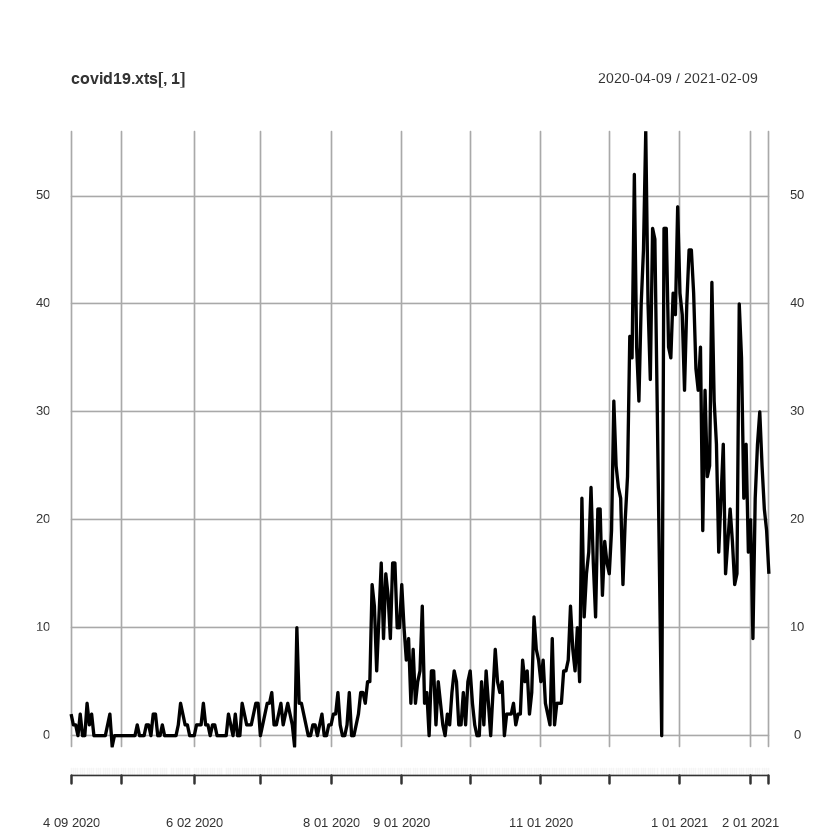

In [362]:
plot(covid19.xts[, 1])

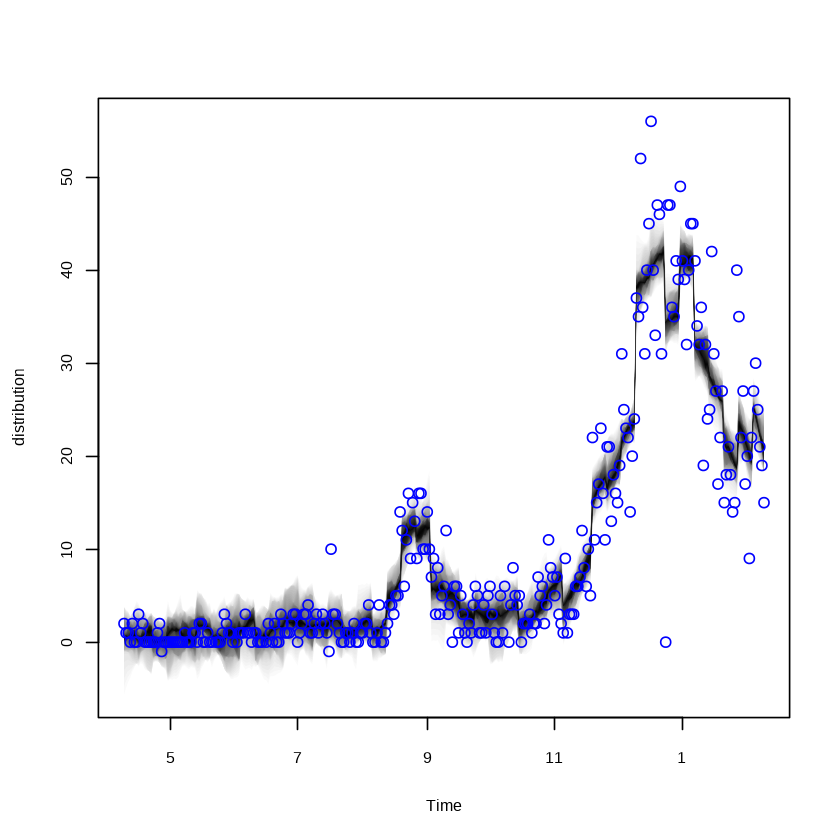

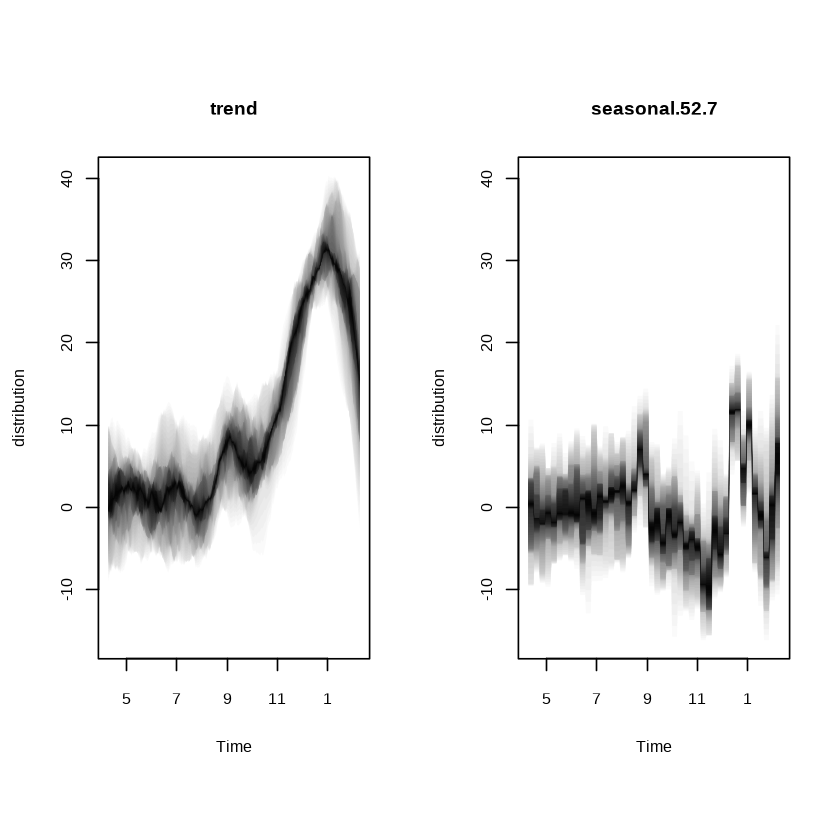

In [363]:
plot(covid19.bayesian.model)
plot(covid19.bayesian.model, "components")

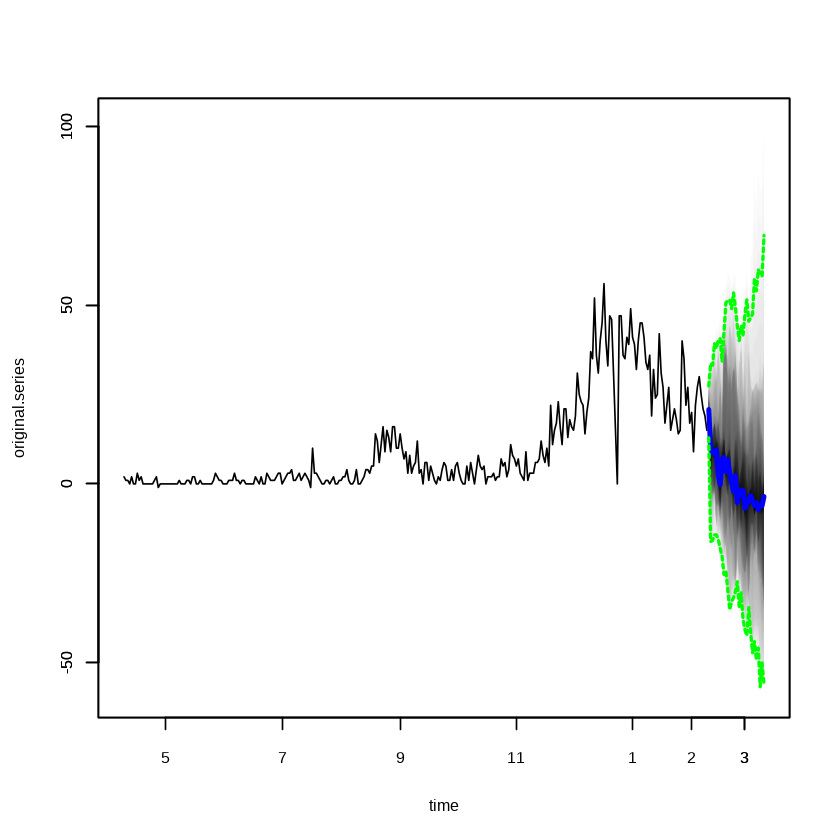

In [367]:
covid19.bayesian.pred <- predict(covid19.bayesian.model, horizon = 30)
plot(covid19.bayesian.pred)